In [1]:
# 3.16.2 获取和读取数据集 
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,nn
import numpy as np
import pandas as pd

In [2]:
#pd.read_csv读取文件
train_data=pd.read_csv('D:/data/train.csv')
test_data=pd.read_csv('D:/data/test.csv')

In [3]:
# 训练数据集包括1460个样本、80个特征和1个标签。 
# 测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。 
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.iloc[0:4,[0,1,2,3,-3,-3,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleType,SalePrice
0,1,60,RL,65.0,WD,WD,208500
1,2,20,RL,80.0,WD,WD,181500
2,3,60,RL,68.0,WD,WD,223500
3,4,70,RL,60.0,WD,WD,140000


In [5]:
# 将所有的训练数据和测试数据的79个特征按样本连结。 pd.concat(,axis=0)axis=0(默认)为按行连结,axis=1为按列连结
# iloc根据索引返回元素
all_features=pd.concat( (train_data.iloc[:,1:-1],test_data.iloc[:,1:]),axis=0 )

In [6]:
# 3.16.3 预处理数据 
# all_features.dtypes返回每一列数据的类型
# all_features.dtypes[all_features.dtypes!='object']为所有数据中类型不为object的数据(即均为数值型数据)，index返回索引
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
# 标准化：将该特征的每个值先减去均值µ再除以标准差σ得到标准化后的每个特征值。
all_features[numeric_features]=all_features[numeric_features].apply( lambda x:(x-x.mean())/(x.std()) )
# 标准化后，每个特征的均值变为0，所以可以直接⽤0来替换缺失值(NaN),fillna(0)将缺失值换为0
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [7]:
# get_dummies将离散数值(如征MSZoning中RL、RM)转成指⽰特征(MSZoning_RL=1、MSZoning_RM=1)
# dummy_na=True将缺失值也当作合法的特征值并为其创建指⽰特征 
all_features=pd.get_dummies(all_features,dummy_na=True)

In [8]:
n_train=train_data.shape[0]
# values属性得到所有特征的值，且为NumPy格式的数据
train_features=nd.array(all_features[:n_train].values)
test_features=nd.array(all_features[n_train:].values)
train_labels=nd.array(train_data.SalePrice.values).reshape((-1,1))

In [9]:
# 3.16.4 训练模型
loss=gloss.L2Loss()
def get_net():
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [10]:
def log_rmse(net,features,labels):
    # 将⼩于1的值设成1，使得取对数时数值更稳定 
    # nd.clip(net(features),1,float('inf'))将net(features)中不在区间[1,inf]的数<1的设为1,>inf的设为inf
    clipped_preds=nd.clip(net(features),1,float('inf'))
    # loss里面有个1/2
    rmse=nd.sqrt( 2*loss(clipped_preds.log(),labels.log() ).mean() )
    return rmse.asscalar()

In [11]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    train_iter=gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)
    # 这⾥使⽤了Adam优化算法
    trainer=gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd':weight_decay})
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [12]:
# 3.16.5 K折交叉验证
# 它将被⽤来选择模型设计并调节超参数。
# get_k_fold_data()返回第i折交叉验证时所需要的训练和验证数据。 
def get_k_fold_data(k,i,X,y):
    # 将原始数据集分为k个子集
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        # slice创建一个切片对象
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        # 返回第i折交叉验证时所需要的训练和验证数据。
        # 第i个为验证数据，其余的k-1个为训练数据 
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=nd.concat(X_train,X_part,dim=0)# dim=0按行连结
            y_train=nd.concat(y_train,y_part,dim=0)
    return X_train,y_train,X_valid,y_valid

In [13]:
# 在K折交叉验证中我们训练K次并返回训练和验证的平均误差。
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):#进行k次训练和验证
        data = get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,'epoch','rmse',
                        range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold %d,train rmse %f,valid rmse %f'%(i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

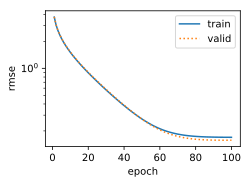

fold 0,train rmse 0.169546,valid rmse 0.157219
fold 1,train rmse 0.162106,valid rmse 0.188083
fold 2,train rmse 0.163567,valid rmse 0.167949
fold 3,train rmse 0.167818,valid rmse 0.154654
fold 4,train rmse 0.162522,valid rmse 0.182732
5-fold validation:avg train rmse 0.165112,avg valid rmse 0.170127


In [14]:
# 3.16.6 模型选择
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg train rmse %f,avg valid rmse %f'%(k,train_l,valid_l))

In [15]:
# 3.16.7 预测并在Kaggle提交结果
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net=get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f' %train_ls[-1])
    preds=net(test_features).asnumpy()
    # 将值赋给'SalePrice'列，若test_data没有则增加这一列
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    # pd.concat(,axis=1)axis=1表示按列连结'Id'、'SalePrice'两列
    submission=pd.concat([ test_data['Id'],test_data['SalePrice'] ],axis=1)
    # submission.to_csv会⽣成⼀个submission.csv⽂件
    # index=False不写行名(索引),默认为True
    submission.to_csv('submiss.csv',index=False)

In [16]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)

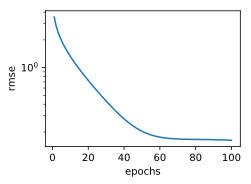

train rmse 0.162462


In [17]:
net=get_net()
train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
print('train rmse %f' %train_ls[-1])
preds=net(test_features).asnumpy()

In [38]:
test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
submission=pd.concat([ test_data['Id'],test_data['SalePrice'] ],1)
submission.to_csv??

In [19]:
nd.array(preds)


[[119381.055]
 [153901.44 ]
 [198613.19 ]
 ...
 [208515.97 ]
 [107345.54 ]
 [240639.6  ]]
<NDArray 1459x1 @cpu(0)>

In [22]:
pd.Series??

In [23]:
pd.concat??

In [24]:
s1 = pd.Series(['a', 'b','e'])
s2 = pd.Series(['c', 'd'])
pd.concat([s1, s2],1)

Object `pd.to_csv` not found.


In [25]:
x = nd.arange(10)
nd.clip(x,1,float('inf'))
x


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
<NDArray 10 @cpu(0)>

In [26]:
idx=slice(0,2)
x[idx]
slice??

In [27]:
nd.sqrt??
nd.clip??

In [28]:
pd.get_dummies??
loss??

In [29]:
pd.core.indexing._iLocIndexer??

In [30]:
pd.concat??

In [31]:
all_features.index??

In [40]:
pd.core.series.Series??
train_data.iloc??
pd.core.indexing._iLocIndexer??